# WatChMaL: MC Dropout Experiments
### Iñaki Erregue Álvarez-Buhilla

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from dictances import bhattacharyya
from sklearn.metrics import *
from utils.utils import *

# 1 - Dropout in Training 

Normal, FC, All, for different dropout rates

In [6]:
base_path = './data/dropout/'

labels = np.load(base_path+'/labels.npy')
test_idxs = np.load(base_path+'/indices.npy')
split_idxs = np.load(base_path+'/IWCD_mPMT_Short_2_class_idxs_xps.npz')

subfolders = [os.path.basename(os.path.normpath(f.path)) for f in os.scandir(base_path) if f.is_dir()]

In [7]:
len(subfolders)

50

In [8]:
data_splitting(split_idxs)

Total num. of events:  2950284
Events for testing: 10.004
Events for validation: 2.399
Events for training: 87.596


In [9]:
results = []
for mode in subfolders:
    results.append(basic_metrics(base_path, labels,mode))

In [17]:
pd.set_option("display.precision", 4)
df = pd.DataFrame(results)

df['total_score'] = df.acc+df.f1+df.auc-df.log_loss

df[['fc_dropout', 'bb_dropout', "learning_rate"]] = df.apply(lambda x: get_dropout_rates(x['model']), axis=1, result_type="expand")

df.sort_values(by='auc', inplace=True, ascending=False)
df = df[['fc_dropout', 'bb_dropout','learning_rate','log_loss', 'acc', 'f1', 'auc']].reset_index(drop=True)

df.head(10)


,fc_dropout,bb_dropout,learning_rate,log_loss,acc,f1,auc
0,0.1,0.00,0.0005,0.5904,0.6836,0.6689,0.7505
1,0.0,0.00,0.0003,0.5919,0.6828,0.6784,0.7493
2,0.1,0.00,0.0003,0.5945,0.6797,0.6871,0.7488
3,0.0,0.00,0.0005,0.5941,0.6800,0.6735,0.7463
4,0.3,0.00,0.0003,0.5940,0.6796,0.6655,0.7457
5,0.2,0.00,0.0003,0.5961,0.6783,0.6728,0.7433
6,0.0,0.05,0.0003,0.5992,0.6752,0.6749,0.7405
7,0.1,0.05,0.0003,0.6008,0.6745,0.6756,0.7402
8,0.2,0.05,0.0003,0.5999,0.6745,0.6686,0.7388
9,0.0,0.10,0.0003,0.5999,0.6740,0.6608,0.7385


In [11]:
df_groupped = df.groupby(['fc_dropout','bb_dropout', 'learning_rate']).mean()
df_groupped.sort_values(by='auc', inplace=True, ascending=False)
df_groupped['auc_std'] = df.groupby(['fc_dropout','bb_dropout','learning_rate'])['auc'].std()
df_groupped['xps'] = df.groupby(['fc_dropout','bb_dropout', 'learning_rate'])['auc'].count()
df_groupped = pd.DataFrame(df_groupped.to_records())
len(df_groupped)

50

In [12]:
plt.rcParams.update({'font.size': 13})

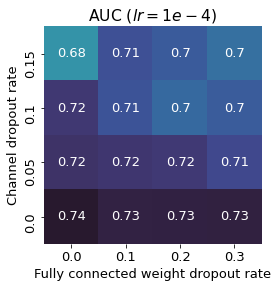

In [13]:
sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==0.0001], values='auc', columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
            annot=True, cmap='mako_r', vmin=0.635, vmax=0.75, square=True, cbar=None) #"flare"
plt.title(r'AUC ($lr=1e-4$)')
plt.xlabel('Fully connected weight dropout rate')
plt.ylabel('Channel dropout rate')
plt.savefig('dropout_1e4.png', dpi=300, bbox_inches = "tight")
plt.show()

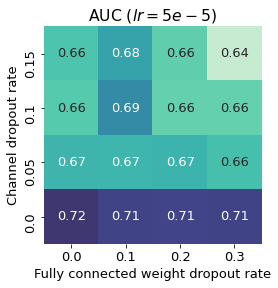

In [14]:
sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==5], values='auc', columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
            annot=True, cmap='mako_r', vmin=0.635, vmax=0.75, square=True, cbar=None) #"flare"
plt.title(r'AUC ($lr=5e-5$)')
plt.xlabel('Fully connected weight dropout rate')
plt.ylabel('Channel dropout rate')
plt.savefig('dropout_5e5.png', dpi=300, bbox_inches = "tight")
plt.show()

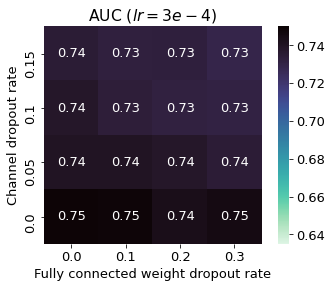

In [15]:
sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==3e-4], values='auc', columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
            annot=True, cmap='mako_r', vmin=0.635, vmax=0.75, square=True) #"flare"
plt.title(r'AUC ($lr=3e-4$)')
plt.xlabel('Fully connected weight dropout rate')
plt.ylabel('Channel dropout rate')
plt.savefig('dropout_3e4.png', dpi=300, bbox_inches = "tight")
plt.show()

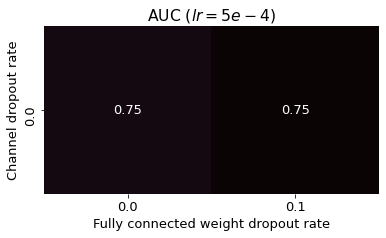

In [18]:
sns.heatmap(pd.pivot_table(df_groupped[df_groupped['learning_rate']==0.0005], values='auc', columns=['fc_dropout'], index=['bb_dropout']).sort_index(ascending=False), 
            annot=True, cmap='mako_r', vmin=0.635, vmax=0.75, square=True, cbar=None) #"flare"
plt.title(r'AUC ($lr=5e-4$)')
plt.xlabel('Fully connected weight dropout rate')
plt.ylabel('Channel dropout rate')
plt.savefig('dropout_1e4.png', dpi=300, bbox_inches = "tight")
plt.show()

Found training logs:  ['./data/dropout/35/log_train_0.csv']


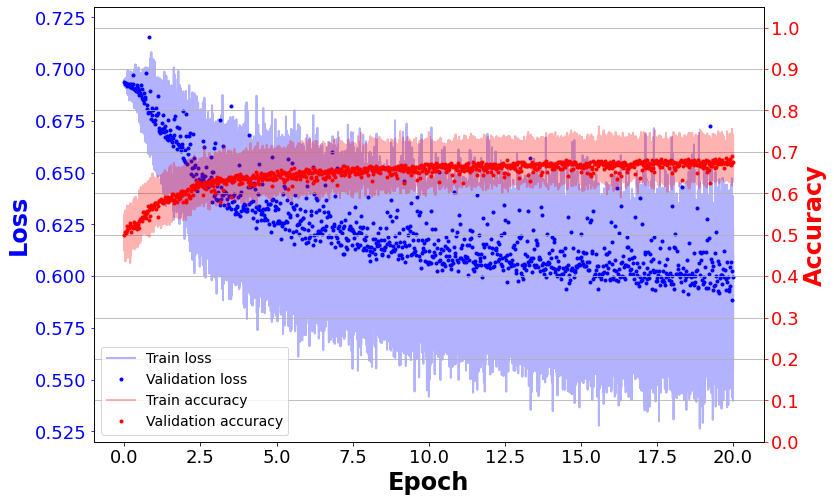

In [13]:
disp_learn_hist(base_path+'35', losslims=(0.52, 0.73))

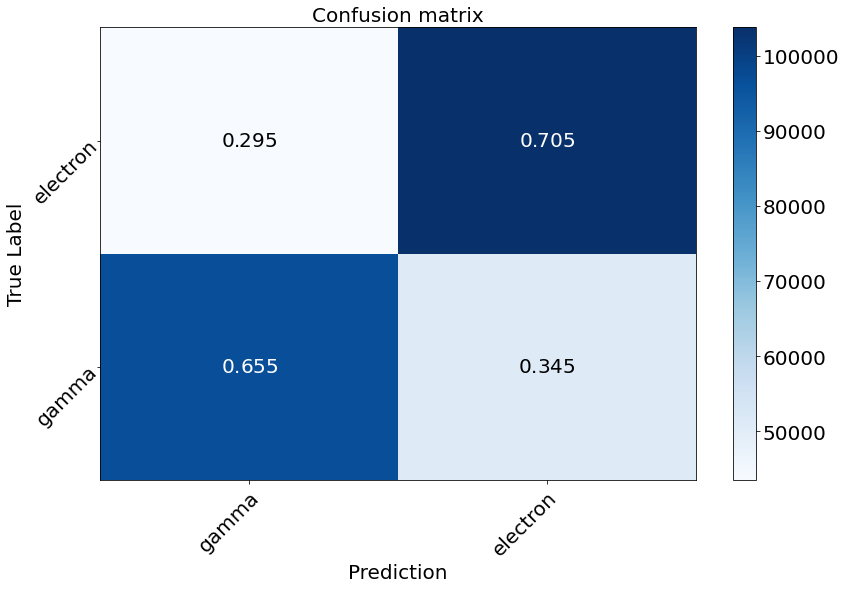

In [7]:
pred = np.load(base_path+'/35/predictions.npy')
plot_cm(labels,pred,np.array(['gamma','electron']))

# 2 - MC Dropout


## 2.1 - Model selection

## 2.2 - Uncertainty assassement

In [4]:
predictions = np.load('./data/uncertainties/predictions.npy')

In [5]:
predictions

array([0, 0, 0, ..., 0, 1, 1])

In [6]:
#[total_variance, entropy, mutual_info, margin_confidence, variation_ratio]
uncertainties = np.load('./data/uncertainties/uncertainties.npy')

predictions = np.expand_dims(np.load('./data/uncertainties/predictions.npy'), axis=1)
probs = np.expand_dims(np.load('./data/uncertainties/softmax.npy')[:,1], axis=1)

uncertainties = np.concatenate((uncertainties,probs,predictions,np.expand_dims(labels, axis=1)),axis=1)

In [7]:
uncertainties_df = pd.DataFrame(
    uncertainties, columns=['total_variance', 'entropy', 'mutual_info', 'margin_confidence', 'variation_ratio', 'probs', 'pred', 'gt'])

In [8]:
uncertainties_df['pred'] = uncertainties_df['pred'].astype(int)
uncertainties_df['gt'] = uncertainties_df['gt'].astype(int)

# normalize entropy
uncertainties_df['entropy'] = uncertainties_df['entropy']/np.log(2)

uncertainties_df['correct_pred'] = np.where(uncertainties_df['pred'] == uncertainties_df['gt'], 1, 0)

In [9]:
uncertainties_df

,total_variance,entropy,mutual_info,margin_confidence,variation_ratio,probs,pred,gt,correct_pred
0,0.089938,0.881926,0.018115,0.405071,0.039216,0.300520,0,0,1
1,0.125455,0.692024,0.047064,0.632879,0.019608,0.185529,0,0,1
2,0.092241,0.568430,0.032322,0.731909,0.000000,0.134046,0,0,1
3,0.030773,0.944677,0.001989,0.275151,0.000000,0.637576,1,0,0
4,0.073516,0.894581,0.012165,0.377553,0.000000,0.311224,0,0,1
...,...,...,...,...,...,...,...,...,...
295151,0.029673,0.948158,0.001846,0.266465,0.000000,0.633233,1,1,1
295152,0.015037,0.995179,0.000447,0.081704,0.000000,0.540852,1,1,1
295153,0.040661,0.980199,0.003322,0.167561,0.019608,0.417351,0,1,0
295154,0.025061,0.954823,0.001308,0.248943,0.000000,0.624472,1,1,1


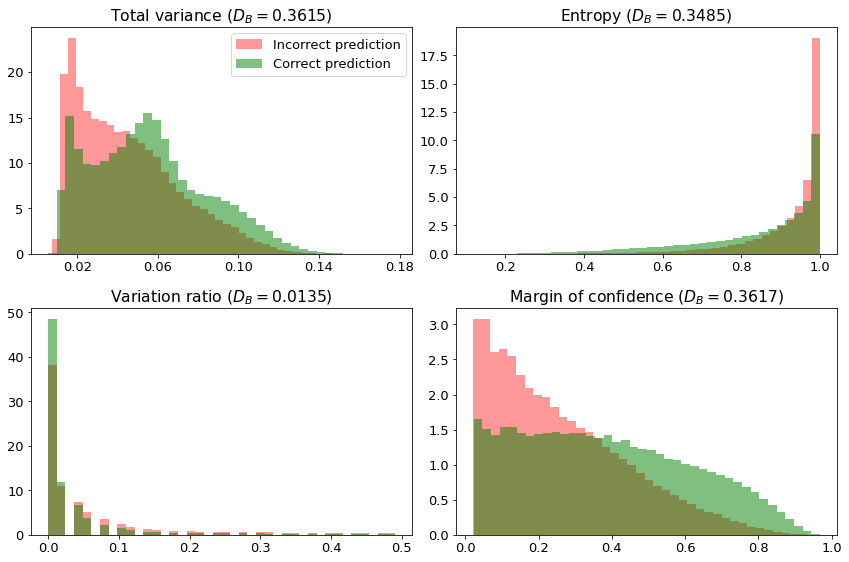

In [44]:
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['total_variance']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['total_variance']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[0,0].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[0,0].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[0,0].set_title(r'Total variance ($D_B=%1.4f$)' % d)
axes[0,0].set_xticks(np.arange(0.02,0.2,0.04))
axes[0,0].legend(['Incorrect prediction', 'Correct prediction'], loc=1)

correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['entropy']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['entropy']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[0,1].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[0,1].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[0,1].set_title(r'Entropy ($D_B=%1.4f$)' % d)

correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['margin_confidence']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['margin_confidence']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[1,1].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[1,1].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[1,1].set_title(r'Margin of confidence ($D_B=%1.4f$)' % d)

correct = uncertainties_df[uncertainties_df['correct_pred'] == 1]['variation_ratio']
incorrect = uncertainties_df[uncertainties_df['correct_pred'] == 0]['variation_ratio']
correct_pmf = correct.value_counts(normalize=True)
incorrect_pmf = incorrect.value_counts(normalize=True)
d = bhattacharyya_d(correct_pmf.reset_index(drop=True).to_dict(),incorrect_pmf.reset_index(drop=True).to_dict())
axes[1,0].hist(incorrect.values, bins=40, alpha=0.4, label='incorrect', color='r', density=1)
axes[1,0].hist(correct.values, bins=40, alpha=0.5, label='correct', color='g', density=1)
axes[1,0].set_title(r'Variation ratio ($D_B=%1.4f$)' % d)

fig.tight_layout()
plt.savefig('uncertainties.png', dpi=300, bbox_inches="tight")
plt.show()

0.0001